## Assignment 2 - IA|BE Data Science Certificate


In this assignment we will analyze claim frequency in the presence of some risk factors. We will perform a random forest and a gbm and compare both methods. Our research question will be which model provides the best deviance between Xgboost and Random Forest after hyper parameter tuning.



#### Import the assignment data 

In [ ]:
import time
import random
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pylab

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import tree



import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

my_data = pd.read_csv("https://gitfront.io/r/katrienantonio/a29071bdc7b2f20f24268be573ef54b68c65168c/IABE-DS-module-1/raw/assignment/assignment_data.csv", delimiter = ",")
my_data.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


In [ ]:
my_data.columns

Index(['AGEPH', 'CODPOSS', 'duree', 'lnexpo', 'nbrtotc', 'nbrtotan',
       'chargtot', 'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc',
       'sportc', 'coverp', 'powerc'],
      dtype='object')

In [ ]:
my_data.shape

(163657, 16)

#### Exploratory Data Analysis

##### ***DB***

In [ ]:
print("my_data")
print(my_data.dtypes.value_counts())

my_data
object     9
float64    4
int64      3
dtype: int64


In [ ]:
print("my_data")
print(my_data.info())
print(my_data.isnull().sum()) # No missing values for each variable

my_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGEPH     163657 non-null  int64  
 1   CODPOSS   163657 non-null  int64  
 2   duree     163657 non-null  float64
 3   lnexpo    163657 non-null  float64
 4   nbrtotc   163657 non-null  int64  
 5   nbrtotan  163657 non-null  float64
 6   chargtot  163657 non-null  float64
 7   agecar    163657 non-null  object 
 8   sexp      163657 non-null  object 
 9   fuelc     163657 non-null  object 
 10  split     163657 non-null  object 
 11  usec      163657 non-null  object 
 12  fleetc    163657 non-null  object 
 13  sportc    163657 non-null  object 
 14  coverp    163657 non-null  object 
 15  powerc    163657 non-null  object 
dtypes: float64(4), int64(3), object(9)
memory usage: 20.0+ MB
None
AGEPH       0
CODPOSS     0
duree       0
lnexpo      0
nbrtotc     0
nbrtotan    0
chargtot 

##### ***Response Variable***

In [ ]:
my_data.nbrtotc.sum()/my_data.duree.sum()

0.1393355156734497

In [ ]:
my_data.nbrtotc.value_counts()

0    145312
1     16602
2      1562
3       162
4        17
5         2
Name: nbrtotc, dtype: int64

In [ ]:
emp_freq = my_data.groupby("nbrtotc").agg(tot_obs = ('nbrtotc', 'count'), tot_expo = ('duree', 'sum'))
emp_freq.reset_index(inplace = True)
emp_freq

,nbrtotc,tot_obs,tot_expo
0,0,145312,128595.947945
1,1,16602,15410.320548
2,2,1562,1447.301370
3,3,162,150.454795
4,4,17,14.328767
5,5,2,1.375342


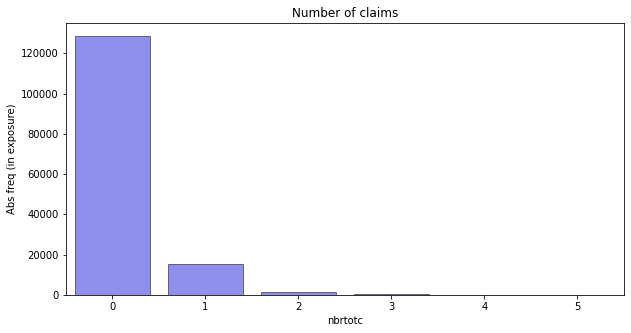

In [ ]:
plt.figure(figsize = (10, 5))
sns.barplot(data = emp_freq, x = "nbrtotc", y = "tot_expo", alpha = 0.5, color = "blue", edgecolor = 'black', linewidth = 1)
plt.ylabel("Abs freq (in exposure)")
plt.xlabel("nbrtotc")
plt.title('Number of claims')
plt.show()

##### ***Explanatory Variables***

In [ ]:
print(my_data.AGEPH.value_counts().sort_index())


17      2
18     17
19    116
20    393
21    704
     ... 
91     12
92     16
93      9
94      3
95      5
Name: AGEPH, Length: 79, dtype: int64


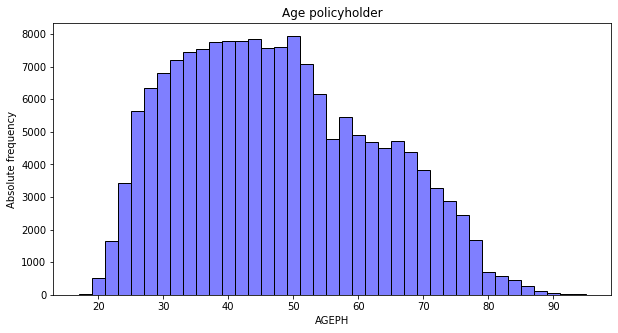

In [ ]:
plt.figure(figsize = (10, 5))
sns.histplot(data = my_data, x = "AGEPH", color = "blue", binwidth = 2, alpha = 0.5)
plt.ylabel("Absolute frequency")
plt.title('Age policyholder')
plt.show()

In [ ]:
my_data['AGEPH_cat'] = np.where(my_data['AGEPH'] < 20, "17-19", np.where(my_data['AGEPH'] < 23 ,"20-22", \
                              np.where(my_data['AGEPH'] < 26, "23-25", np.where(my_data['AGEPH'] < 31, "26-30", \
                              np.where(my_data['AGEPH'] < 36, "31-35", np.where(my_data['AGEPH'] < 41, "36-40", \
                              np.where(my_data['AGEPH'] < 46, "41-45", np.where(my_data['AGEPH'] < 51, "46-50", \
                              np.where(my_data['AGEPH'] < 56, "51-55", np.where(my_data['AGEPH'] < 61, "56-60", \
                              np.where(my_data['AGEPH'] < 66, "61-65", np.where(my_data['AGEPH'] < 71, "66-70", \
                              np.where(my_data['AGEPH'] < 76, "71-75", np.where(my_data['AGEPH'] < 81, "76-80", ">80"))))))))))))))

In [ ]:
my_data['AGEPH_cat'].value_counts().sort_index()

17-19      135
20-22     2050
23-25     6092
26-30    16074
31-35    18362
36-40    19337
41-45    19539
46-50    19183
51-55    15728
56-60    12621
61-65    11509
66-70    10606
71-75     7432
76-80     3505
>80       1484
Name: AGEPH_cat, dtype: int64

In [ ]:
print(my_data.CODPOSS.value_counts().sort_index())

1000    1181
1030     928
1040     433
1050     643
1060     345
        ... 
9950     110
9960     185
9970      48
9980      39
9990     136
Name: CODPOSS, Length: 583, dtype: int64


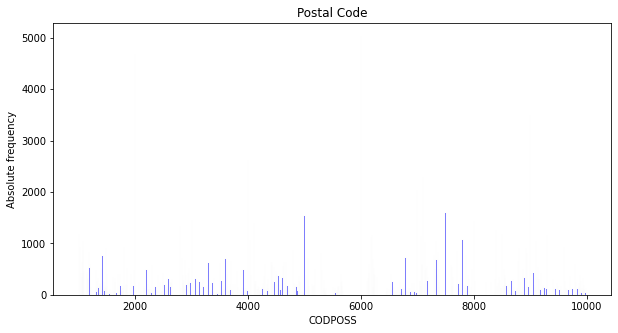

In [ ]:
plt.figure(figsize = (10, 5))
sns.histplot(data = my_data, x = "CODPOSS", color = "blue", binwidth = 2, alpha = 0.5)
plt.ylabel("Absolute frequency")
plt.title('Postal Code')
plt.show()

In [ ]:
print(my_data.agecar.value_counts().sort_index())

0-1      7766
2-5     51559
6-10    67151
>10     37181
Name: agecar, dtype: int64


In [ ]:
my_data.sexp.value_counts()

Male      120434
Female     43223
Name: sexp, dtype: int64

In [ ]:
my_data.fuelc.value_counts()

Petrol    113210
Gasoil     50447
Name: fuelc, dtype: int64

In [ ]:
my_data.split.value_counts()

Once       81479
Twice      45961
Monthly    23599
Thrice     12618
Name: split, dtype: int64

In [ ]:
my_data.usec.value_counts()

Private         155652
Professional      8005
Name: usec, dtype: int64

In [ ]:
my_data.fleetc.value_counts()

No     158428
Yes      5229
Name: fleetc, dtype: int64

In [ ]:
my_data.sportc.value_counts()

No     162145
Yes      1512
Name: sportc, dtype: int64

In [ ]:
my_data.coverp.value_counts()

MTPL       95409
MTPL+      46073
MTPL+++    22175
Name: coverp, dtype: int64

In [ ]:
my_data.powerc.value_counts()

<66       119809
66-110     42188
>110        1660
Name: powerc, dtype: int64

In [ ]:
for c in ["agecar","sexp","fuelc","split","usec","fleetc","sportc","coverp","powerc","AGEPH_cat"]:
    my_data[c]=pd.Categorical(my_data[c])

my_data["split"] = my_data["split"].cat.reorder_categories(['Once','Twice','Thrice','Monthly'])
my_data["powerc"] = my_data["powerc"].cat.reorder_categories(['<66', '66-110','>110'])

my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163657 entries, 0 to 163656
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   AGEPH      163657 non-null  int64   
 1   CODPOSS    163657 non-null  int64   
 2   duree      163657 non-null  float64 
 3   lnexpo     163657 non-null  float64 
 4   nbrtotc    163657 non-null  int64   
 5   nbrtotan   163657 non-null  float64 
 6   chargtot   163657 non-null  float64 
 7   agecar     163657 non-null  category
 8   sexp       163657 non-null  category
 9   fuelc      163657 non-null  category
 10  split      163657 non-null  category
 11  usec       163657 non-null  category
 12  fleetc     163657 non-null  category
 13  sportc     163657 non-null  category
 14  coverp     163657 non-null  category
 15  powerc     163657 non-null  category
 16  AGEPH_cat  163657 non-null  category
dtypes: category(10), float64(4), int64(3)
memory usage: 10.3 MB


##### ***One Way Analysis***

In [ ]:
def my_data_description(variable):
    
    Nbr = my_data[['nbrtotc']].groupby([my_data[variable]]).sum().reset_index()
    exp = my_data[['duree']].groupby([my_data[variable]]).sum().reset_index()
    obs = pd.merge(Nbr,exp)
    obs['Freq']=obs['nbrtotc']/obs['duree']
   
    return(obs)

In [ ]:
def my_data_description_plot(variable):

    plt.rcParams['figure.figsize'] = [15, 6]
    table_to_plot=table.loc[:,[variable,'duree','Freq']]
    table_to_plot.plot(kind='bar', secondary_y='duree', rot=0)
    plt.xticks(range(table_to_plot.shape[0]),list(table_to_plot.iloc[:,0]))
    plot=plt.show()
    
    return(plot)

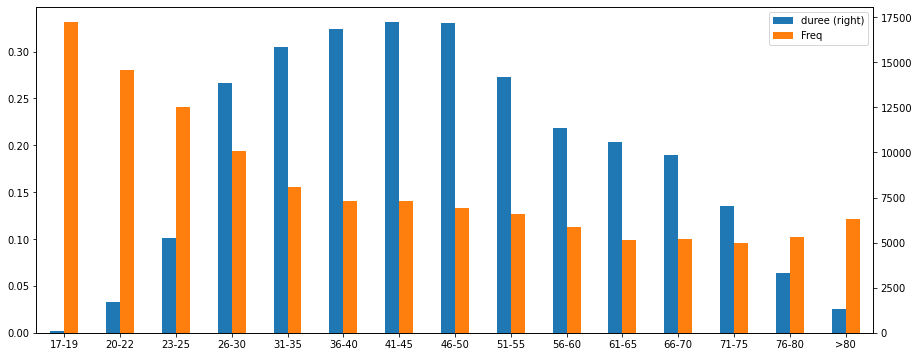

In [ ]:
table=my_data_description("AGEPH_cat")
my_data_description_plot("AGEPH_cat")

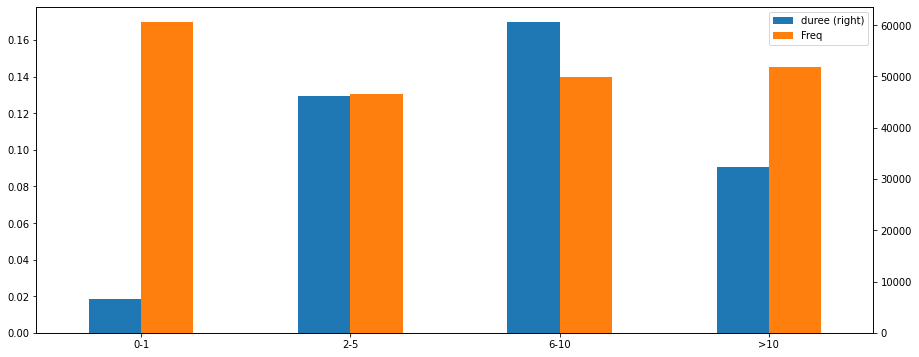

In [ ]:
table=my_data_description("agecar")
my_data_description_plot("agecar")

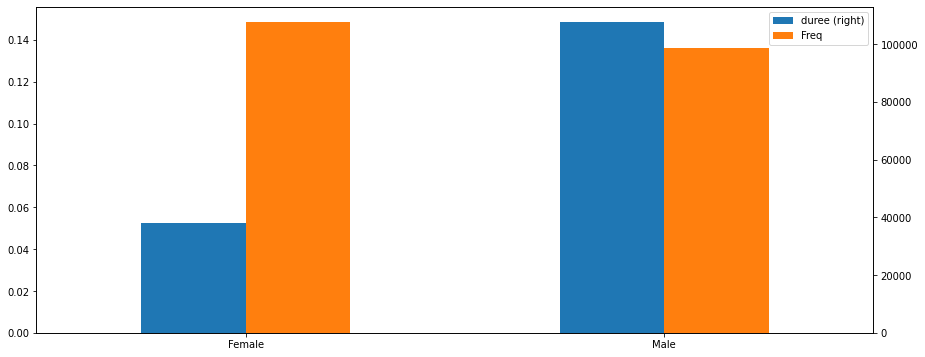

In [ ]:
table=my_data_description("sexp")
my_data_description_plot("sexp")

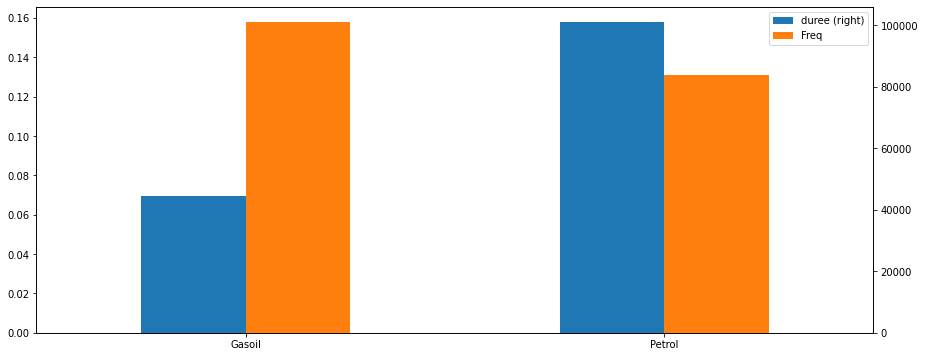

In [ ]:
table=my_data_description("fuelc")
my_data_description_plot("fuelc")

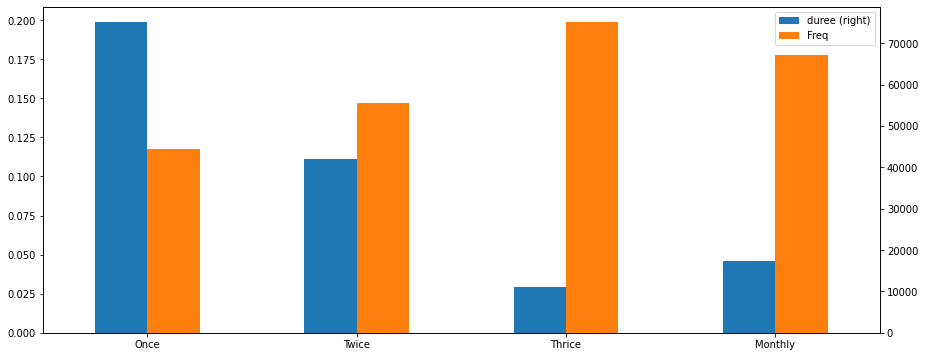

In [ ]:
table=my_data_description("split")
my_data_description_plot("split")

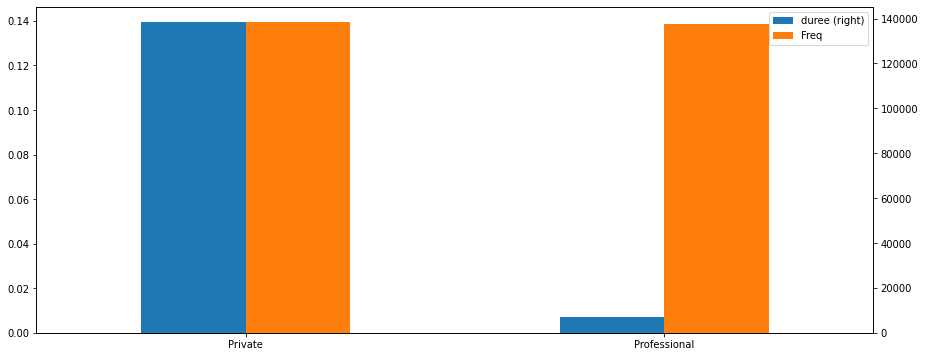

In [ ]:
table=my_data_description("usec")
my_data_description_plot("usec")

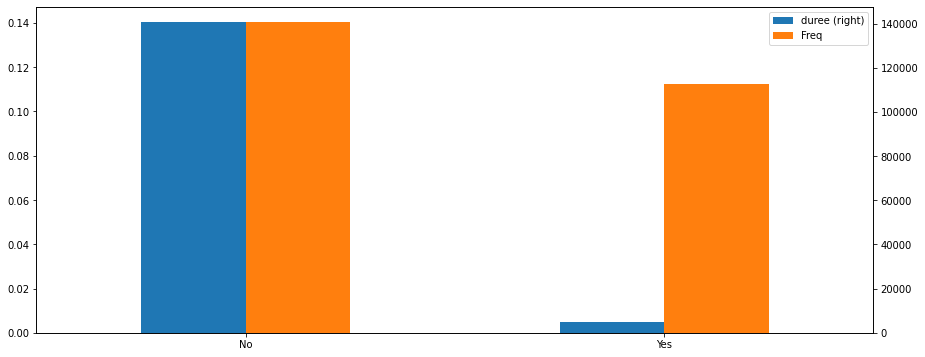

In [ ]:
table=my_data_description("fleetc")
my_data_description_plot("fleetc")

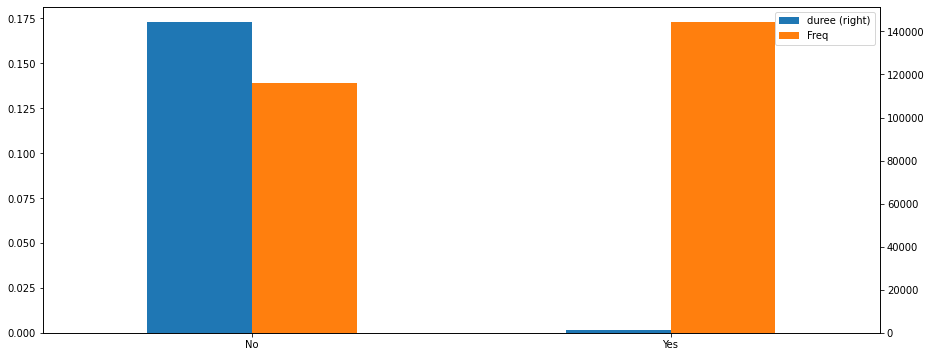

In [ ]:
table=my_data_description("sportc")
my_data_description_plot("sportc")

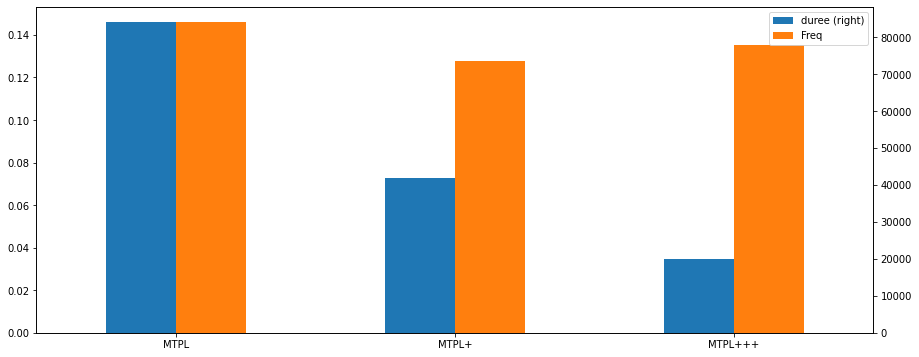

In [ ]:
table=my_data_description("coverp")
my_data_description_plot("coverp")

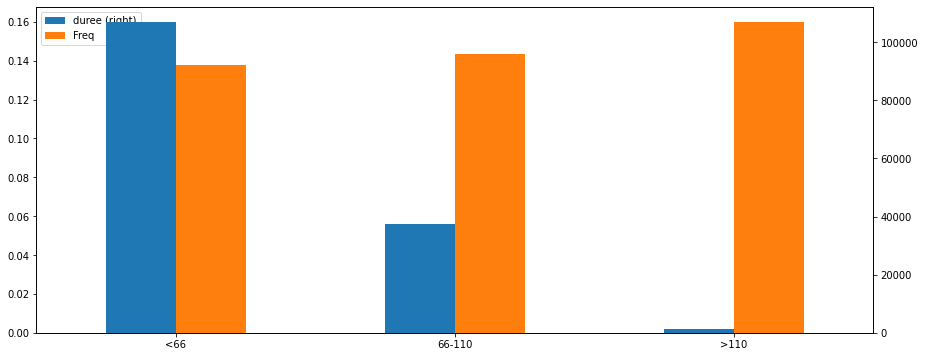

In [ ]:
table=my_data_description("powerc")
my_data_description_plot("powerc")

#### Method 1 : Random Forest

##### ***Train-test split and one hot encoding***

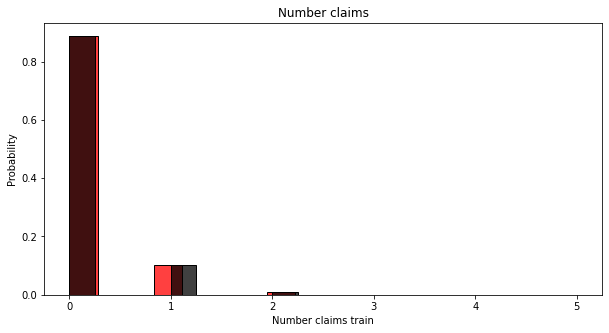

In [ ]:
np.random.seed(123)

my_data_X = my_data.drop(labels=['AGEPH_cat','CODPOSS','lnexpo','nbrtotc','nbrtotan','chargtot'], axis=1) 
my_data_X_train, my_data_X_test, my_data_y_train, my_data_y_test = train_test_split(my_data_X, my_data.nbrtotc, test_size=0.2, stratify=my_data.nbrtotc)

X_train=my_data_X_train
y_train=my_data_y_train
Duree_train=my_data_X_train['duree']
X_train_1=my_data_X_train.drop(labels=['duree'],axis=1)
X_train_2=pd.get_dummies(data=X_train_1,drop_first=True)
y_train_2=my_data_y_train/my_data_X_train['duree']

X_test=my_data_X_test
y_test=my_data_y_test
Duree_test=my_data_X_test['duree']
X_test_1=my_data_X_test.drop(labels=['duree'],axis=1)
X_test_2=pd.get_dummies(data=X_test_1,drop_first=True)
y_test_2=my_data_y_test/my_data_X_test['duree']

#create dataframe from different vector lengths
df1= pd.DataFrame(my_data_y_train)
df2= pd.DataFrame(my_data_y_test)
plot_pd = pd.concat([df1,df2], ignore_index=True, axis=1)
#rename columns for x-label
plot_pd.columns = ['Number claims train', 'Number claims test']
#plot 
fig, axs = plt.subplots(ncols=1, figsize=(10,5));
sns.histplot(plot_pd['Number claims train'], ax = axs, color='r',stat="probability").set(title='Number claims');
sns.histplot(plot_pd['Number claims test'], ax = axs, color='k',stat="probability");
plt.show()

##### ***A first Random Forest***

In [ ]:
class_rf = RandomForestRegressor(n_estimators=100,criterion='poisson',max_depth = 50, max_features='sqrt',random_state = 0)
# Starting time
start = time.time()
# Training
reg_rf=class_rf.fit(X_train_2, y_train_2, sample_weight=my_data_X_train['duree'])
# Elapsed time
end = time.time()
print(end - start)


10.845092535018921


In [ ]:
def DeviancePoisson_scikit(lambdahat,N,v):

    nlogn = np.array([np.nan for i in range(v.size)])
    dev = np.array([np.nan for i in range(v.size)])
    
    for i in range(v.size):
        if N[i]==0:
            nlogn[i] = 0
        else:
            nlogn[i] = N[i]*math.log(N[i]/(lambdahat[i]*v[i]))
            
        dev[i] = ( nlogn[i] - (N[i] - lambdahat[i]*v[i]) )
        
    return(dev.sum()/v.sum())

In [ ]:
# Prediction
y_pred_train = reg_rf.predict(X_train_2)
y_pred_test = reg_rf.predict(X_test_2)

print("Poisson deviance on training set:", DeviancePoisson_scikit(np.array(y_pred_train),np.array(y_train),np.array(my_data_X_train['duree'])))
print("Poisson deviance on testing set:", DeviancePoisson_scikit(np.array(y_pred_test),np.array(y_test),np.array(my_data_X_test['duree'])))


Poisson deviance on training set: 0.2691652659381797
Poisson deviance on testing set: 0.31458854260896596


##### ***Hyper parameter Tuning***

###### Impact of the hyper parameters

In the following section, we investigate the impact of the following hyperparameters:
* n_estimators : the number of trees in the forest
* max_depth : the maximum depth of the tree
* min_samples_split : the minimum number of samples required to split an internal node
* min_samples_leaf : the minimum number of samples required to be at a leaf node.


**Number of trees**

In [ ]:
num_trees = np.append([1], np.arange(10, 101, 10))
num_k_fold = 5
scores = pd.DataFrame(columns = ['Number of trees', 'Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold * len(num_trees), 3)))

# Starting time
start_global = time.time()

# Loop over the number of trees
for j in range(len(num_trees)):
    i = 0
    
    # Initiate k-fold object
    kf = KFold(n_splits = num_k_fold, shuffle = True)
    
    # Record starting time
    start = time.time()
    
    # k-fold cross-validation for the selected number of trees
    for train, test in kf.split(X_train_2):
        # Select training and testing subsets
        X_train_cv, y_train_cv, Duree_train_cv = X_train_2.iloc[train], y_train_2.iloc[train], Duree_train.iloc[train]
        X_test_cv, y_test_cv, Duree_test_cv = X_train_2.iloc[test], y_train_2.iloc[test], Duree_train.iloc[test]
        
        # Training
        class_rf = RandomForestRegressor(criterion = "poisson", max_features = "sqrt",
                                   n_estimators = num_trees[j], max_depth = 50, random_state = 0, n_jobs = 1)
        reg_rf=class_rf.fit(X_train_cv, y_train_cv, sample_weight= Duree_train_cv)
        
        # Prediction
        y_pred_train_cv = reg_rf.predict(X_train_cv)
        y_pred_test_cv = reg_rf.predict(X_test_cv)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Number of trees'] = num_trees[j]
        scores.at[index, 'Mean Deviance (testing)'] = DeviancePoisson_scikit(np.array(y_pred_test_cv),np.array(y_test_cv*Duree_test_cv),np.array(Duree_test_cv))
        scores.at[index, 'Mean Deviance (training)'] = DeviancePoisson_scikit(np.array(y_pred_train_cv),np.array(y_train_cv*Duree_train_cv),np.array(Duree_train_cv))
        i = i + 1
    
    # Elasped time for the k-fold step
    end = time.time()
    elapsed = end - start
    print('Step', j + 1, 'completed (', elapsed, 'sec)...')

# Global elapsed time
end_global = time.time()
elapsed = end_global - start_global
print('Total time:', elapsed, 'sec!')


Step 1 completed ( 1.8082287311553955 sec)...
Step 2 completed ( 6.775289535522461 sec)...
Step 3 completed ( 12.075722694396973 sec)...
Step 4 completed ( 17.649260759353638 sec)...
Step 5 completed ( 22.959863901138306 sec)...
Step 6 completed ( 28.340275049209595 sec)...
Step 7 completed ( 33.76645016670227 sec)...
Step 8 completed ( 39.358623027801514 sec)...
Step 9 completed ( 44.429866313934326 sec)...
Step 10 completed ( 49.91442370414734 sec)...
Step 11 completed ( 55.284947633743286 sec)...
Total time: 312.374657869339 sec!


In [ ]:
gp = scores.groupby('Number of trees')
means = gp.mean()
means

,Mean Deviance (testing),Mean Deviance (training)
Number of trees,,
1.0,0.341291,0.301231
10.0,0.317396,0.270555
20.0,0.317067,0.268283
30.0,0.316482,0.267269
40.0,0.315047,0.267372
50.0,0.314699,0.267113
60.0,0.314679,0.266713
70.0,0.314250,0.266498
80.0,0.314731,0.266483


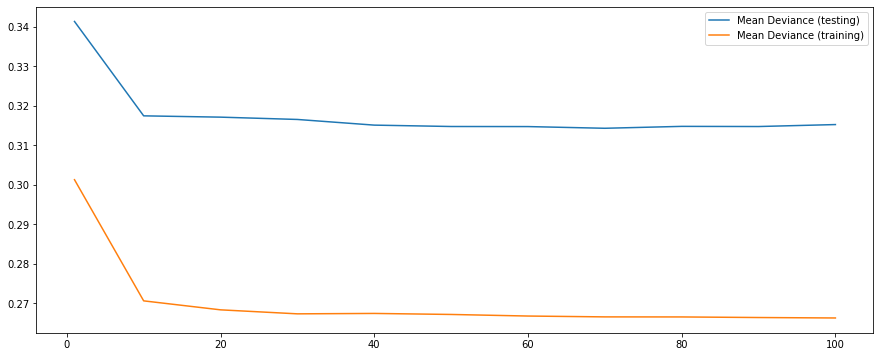

In [ ]:
measures = ['Mean Deviance (testing)','Mean Deviance (training)']
plt.figure()
plt.plot(means[measures])
plt.legend(measures)
plt.show()

**Maximum depth of the tree**

In [ ]:
depth_tree = np.append([1], np.arange(10, 101, 10))
num_k_fold = 5
scores = pd.DataFrame(columns = ['Depth of the tree', 'Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold * len(depth_tree), 3)))

# Starting time
start_global = time.time()

# Loop over the depth of the tree
for j in range(len(depth_tree)):
    i = 0
    
    # Initiate k-fold object
    kf = KFold(n_splits = num_k_fold, shuffle = True)
    
    # Record starting time
    start = time.time()
    
    # k-fold cross-validation for the selected depth of the tree
    for train, test in kf.split(X_train_2):
        # Select training and testing subsets
        X_train_cv, y_train_cv, Duree_train_cv = X_train_2.iloc[train], y_train_2.iloc[train], Duree_train.iloc[train]
        X_test_cv, y_test_cv, Duree_test_cv = X_train_2.iloc[test], y_train_2.iloc[test], Duree_train.iloc[test]
        
        # Training
        class_rf = RandomForestRegressor(criterion = "poisson", max_features = "sqrt",
                                   n_estimators = 100, max_depth = depth_tree[j], random_state = 0, n_jobs = 1)
        reg_rf=class_rf.fit(X_train_cv, y_train_cv, sample_weight= Duree_train_cv)
        
        # Prediction
        y_pred_train_cv = reg_rf.predict(X_train_cv)
        y_pred_test_cv = reg_rf.predict(X_test_cv)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Depth of the tree'] = depth_tree[j]
        scores.at[index, 'Mean Deviance (testing)'] = DeviancePoisson_scikit(np.array(y_pred_test_cv),np.array(y_test_cv*Duree_test_cv),np.array(Duree_test_cv))
        scores.at[index, 'Mean Deviance (training)'] = DeviancePoisson_scikit(np.array(y_pred_train_cv),np.array(y_train_cv*Duree_train_cv),np.array(Duree_train_cv))
        i = i + 1
    
    # Elasped time for the k-fold step
    end = time.time()
    elapsed = end - start
    print('Step', j + 1, 'completed (', elapsed, 'sec)...')

# Global elapsed time
end_global = time.time()
elapsed = end_global - start_global
print('Total time:', elapsed, 'sec!')


Step 1 completed ( 6.6816565990448 sec)...
Step 2 completed ( 29.242548942565918 sec)...
Step 3 completed ( 48.17968487739563 sec)...
Step 4 completed ( 55.0025098323822 sec)...
Step 5 completed ( 55.256596326828 sec)...
Step 6 completed ( 55.358633518218994 sec)...
Step 7 completed ( 55.50013446807861 sec)...
Step 8 completed ( 55.04474973678589 sec)...
Step 9 completed ( 55.22763776779175 sec)...
Step 10 completed ( 55.54601001739502 sec)...
Step 11 completed ( 55.5246319770813 sec)...
Total time: 526.5841767787933 sec!


In [ ]:
gp = scores.groupby('Depth of the tree')
means = gp.mean()
means

,Mean Deviance (testing),Mean Deviance (training)
Depth of the tree,,
1.0,0.309535,0.309513
10.0,0.307430,0.304169
20.0,0.308970,0.279006
30.0,0.314900,0.266713
40.0,0.314462,0.266386
50.0,0.314977,0.266297
60.0,0.314213,0.266458
70.0,0.314385,0.266408
80.0,0.314896,0.266311


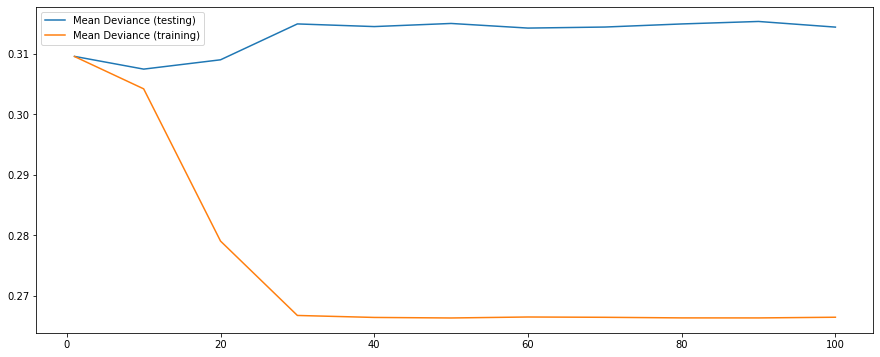

In [ ]:
measures = ['Mean Deviance (testing)','Mean Deviance (training)']
plt.figure()
plt.plot(means[measures])
plt.legend(measures)
plt.show()

**Minimum number of samples required to split an internal node**

In [ ]:
num_split = np.arange(2, 11, 1)
num_k_fold = 5
scores = pd.DataFrame(columns = ['Number to split', 'Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold * len(num_split), 3)))

# Starting time
start_global = time.time()

# Loop over the number to split
for j in range(len(num_split)):
    i = 0
    
    # Initiate k-fold object
    kf = KFold(n_splits = num_k_fold, shuffle = True)
    
    # Record starting time
    start = time.time()
    
    # k-fold cross-validation for the selected number to split
    for train, test in kf.split(X_train_2):
        # Select training and testing subsets
        X_train_cv, y_train_cv, Duree_train_cv = X_train_2.iloc[train], y_train_2.iloc[train], Duree_train.iloc[train]
        X_test_cv, y_test_cv, Duree_test_cv = X_train_2.iloc[test], y_train_2.iloc[test], Duree_train.iloc[test]
        
        # Training
        class_rf = RandomForestRegressor(criterion = "poisson", max_features = "sqrt",
                                   n_estimators = 100, max_depth = 50, min_samples_split = num_split[j], 
                                   random_state = 0, n_jobs = 1)
        reg_rf=class_rf.fit(X_train_cv, y_train_cv, sample_weight= Duree_train_cv)
        
        # Prediction
        y_pred_train_cv = reg_rf.predict(X_train_cv)
        y_pred_test_cv = reg_rf.predict(X_test_cv)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Number to split'] = num_split[j]
        scores.at[index, 'Mean Deviance (testing)'] = DeviancePoisson_scikit(np.array(y_pred_test_cv),np.array(y_test_cv*Duree_test_cv),np.array(Duree_test_cv))
        scores.at[index, 'Mean Deviance (training)'] = DeviancePoisson_scikit(np.array(y_pred_train_cv),np.array(y_train_cv*Duree_train_cv),np.array(Duree_train_cv))
        i = i + 1
    
    # Elasped time for the k-fold step
    end = time.time()
    elapsed = end - start
    print('Step', j + 1, 'completed (', elapsed, 'sec)...')

# Global elapsed time
end_global = time.time()
elapsed = end_global - start_global
print('Total time:', elapsed, 'sec!')


Step 1 completed ( 55.39097189903259 sec)...
Step 2 completed ( 54.605303049087524 sec)...
Step 3 completed ( 54.596935510635376 sec)...
Step 4 completed ( 55.27218151092529 sec)...
Step 5 completed ( 55.17992901802063 sec)...
Step 6 completed ( 55.147953271865845 sec)...
Step 7 completed ( 55.02551889419556 sec)...
Step 8 completed ( 55.26871371269226 sec)...
Step 9 completed ( 55.023972272872925 sec)...
Total time: 495.5231673717499 sec!


In [ ]:
gp = scores.groupby('Number to split')
means = gp.mean()
means

,Mean Deviance (testing),Mean Deviance (training)
Number to split,,
2.0,0.314940,0.266220
3.0,0.314931,0.266493
4.0,0.314582,0.266291
5.0,0.314502,0.266493
6.0,0.313983,0.266851
7.0,0.314409,0.266992
8.0,0.313634,0.267173
9.0,0.314384,0.267271
10.0,0.313710,0.267719


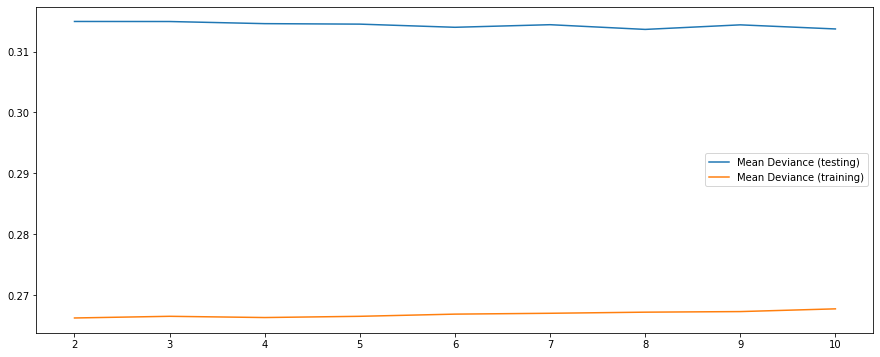

In [ ]:
measures = ['Mean Deviance (testing)','Mean Deviance (training)']
plt.figure()
plt.plot(means[measures])
plt.legend(measures)
plt.show()

**Minimum number of samples required to be at a leaf node**

In [ ]:
num_leaf = np.append([1],np.arange(start = 50, stop = 501, step = 50))
num_k_fold = 5
scores = pd.DataFrame(columns = ['Number for leaf', 'Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold * len(num_leaf), 3)))

# Starting time
start_global = time.time()

# Loop over the number for leaf
for j in range(len(num_leaf)):
    i = 0
    
    # Initiate k-fold object
    kf = KFold(n_splits = num_k_fold, shuffle = True)
    
    # Record starting time
    start = time.time()
    
    # k-fold cross-validation for the selected number for leaf
    for train, test in kf.split(X_train_2):
        # Select training and testing subsets
        X_train_cv, y_train_cv, Duree_train_cv = X_train_2.iloc[train], y_train_2.iloc[train], Duree_train.iloc[train]
        X_test_cv, y_test_cv, Duree_test_cv = X_train_2.iloc[test], y_train_2.iloc[test], Duree_train.iloc[test]
        
        # Training
        class_rf = RandomForestRegressor(criterion = "poisson", max_features = "sqrt",
                                   n_estimators = 100, max_depth = 50, min_samples_leaf = num_leaf[j],
                                   random_state = 0, n_jobs = 1,)
        reg_rf=class_rf.fit(X_train_cv, y_train_cv, sample_weight= Duree_train_cv)
        
        # Prediction
        y_pred_train_cv = reg_rf.predict(X_train_cv)
        y_pred_test_cv = reg_rf.predict(X_test_cv)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Number for leaf'] = num_leaf[j]
        scores.at[index, 'Mean Deviance (testing)'] = DeviancePoisson_scikit(np.array(y_pred_test_cv),np.array(y_test_cv*Duree_test_cv),np.array(Duree_test_cv))
        scores.at[index, 'Mean Deviance (training)'] = DeviancePoisson_scikit(np.array(y_pred_train_cv),np.array(y_train_cv*Duree_train_cv),np.array(Duree_train_cv))
        i = i + 1
    
    # Elasped time for the k-fold step
    end = time.time()
    elapsed = end - start
    print('Step', j + 1, 'completed (', elapsed, 'sec)...')

# Global elapsed time
end_global = time.time()
elapsed = end_global - start_global
print('Total time:', elapsed, 'sec!')


Step 1 completed ( 55.84931969642639 sec)...
Step 2 completed ( 38.3892924785614 sec)...
Step 3 completed ( 34.14306926727295 sec)...
Step 4 completed ( 31.563315868377686 sec)...
Step 5 completed ( 29.80270004272461 sec)...
Step 6 completed ( 28.657790422439575 sec)...
Step 7 completed ( 27.89190697669983 sec)...
Step 8 completed ( 27.47639513015747 sec)...
Step 9 completed ( 26.98468828201294 sec)...
Step 10 completed ( 26.429246425628662 sec)...
Step 11 completed ( 26.00547957420349 sec)...
Total time: 353.21004486083984 sec!


In [ ]:
gp = scores.groupby('Number for leaf')
means = gp.mean()
means

,Mean Deviance (testing),Mean Deviance (training)
Number for leaf,,
1.0,0.314618,0.266355
50.0,0.304982,0.299562
100.0,0.305255,0.302708
150.0,0.305463,0.303842
200.0,0.305618,0.304391
250.0,0.305833,0.304714
300.0,0.305899,0.304976
350.0,0.305994,0.305199
400.0,0.306051,0.305294


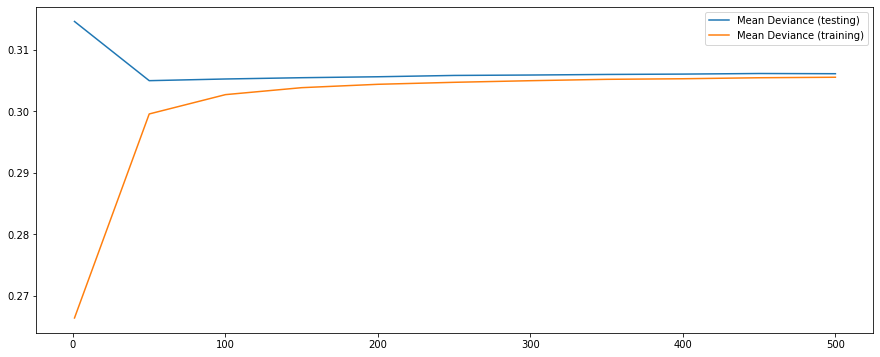

In [ ]:
measures = ['Mean Deviance (testing)','Mean Deviance (training)']
plt.figure()
plt.plot(means[measures])
plt.legend(measures)
plt.show()

###### Random search

We will use RandomizedSearchCV to implement a randomized search on three hyper parameters (n_estimators, max_depth and min_samples_leaf).

In [ ]:
num_trees = np.append([1], np.arange(10, 101, 10))
depth_tree = np.append([1], np.arange(10, 101, 10))
min_sample_per_leaf = np.append([1],np.arange(start = 50, stop = 501, step = 50))

random_grid = {'n_estimators': num_trees,
               'max_depth': depth_tree,
               'min_samples_leaf': min_sample_per_leaf}
random_grid

{'max_depth': array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 'min_samples_leaf': array([  1,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500]),
 'n_estimators': array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])}

In [ ]:
class_rf = RandomForestRegressor(random_state=0)
class_rf_random = RandomizedSearchCV(estimator = class_rf, param_distributions = random_grid, n_iter = 200, cv = 5, 
                                     verbose=2, random_state=0, n_jobs = -1, scoring='neg_mean_poisson_deviance')
reg_rf_random=class_rf_random.fit(X_train_2, y_train_2, sample_weight = Duree_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.75949584 -0.75964757 -0.75948145         nan         nan -0.76040298
 -0.77214308 -0.78204706 -0.75935646 -0.76641492 -0.75930032 -0.7595764
 -0.75971934 -0.75964757 -0.75944211 -0.75971934 -0.75971517 -0.7609233
 -0.76653391 -0.76899814 -0.76009034 -0.75971517 -0.75980927 -0.76899724
 -0.76897922 -0.76886148 -0.76897922 -0.76030608 -0.75965804 -0.75995667
 -0.75988805 -0.76898095 -0.75968265 -0.76957288 -0.76236573 -0.76119035
 -0.75971572 -0.75980927 -0.75955884 -0.76858137 -0.76075137 -0.75935366
 -0.76513719 -0.75947739         nan -0.7596131          nan -0.76075459
 -0.77376217         nan -0.76625882 -0.75937214 -0.7597159  -0.75997197
 -0.76410565 -0.75981065 -0.75972206 -0.76659244 -0.75996109 -0.75962016
 -0.75993469 -0.75965804 -0.76887577 -0.76858137 -0.76709876 -0.75944211
 -0.76211716 -0.76631404 -0.7593661  -0.76513719 -0.7597159 

In [ ]:
reg_rf_random.best_params_

{'max_depth': 30, 'min_samples_leaf': 450, 'n_estimators': 100}

In [ ]:
best_index = np.nonzero(reg_rf_random.cv_results_["rank_test_score"] == 1)[0][0]

Z=-reg_rf_random.cv_results_["mean_test_score"].astype(float)
Z[best_index]

0.7593003211454353

###### Grid search

We will perform a grid search around the best parameters found during the random search.

In [ ]:
param_grid = {'n_estimators': np.arange(start = 90, stop = 121, step = 5),
              'max_depth': np.arange(start = 10, stop = 41, step = 5),
              'min_samples_leaf': np.arange(start = 430, stop = 471, step = 10)}
param_grid

{'max_depth': array([10, 15, 20, 25, 30, 35, 40]),
 'min_samples_leaf': array([430, 440, 450, 460, 470]),
 'n_estimators': array([ 90,  95, 100, 105, 110, 115, 120])}

In [ ]:
class_rf = RandomForestRegressor(random_state=0)
reg_rf_grid = GridSearchCV(estimator = class_rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_poisson_deviance')
reg_rf_grid.fit(X_train_2, y_train_2, sample_weight = Duree_train)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': array([10, 15, 20, 25, 30, 35, 40]),
                         'min_samples_leaf': array([430, 440, 450, 460, 470]),
                         'n_estimators': array([ 90,  95, 100, 105, 110, 115, 120])},
             scoring='neg_mean_poisson_deviance', verbose=2)

In [ ]:
reg_rf_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 450, 'n_estimators': 115}

In [ ]:
best_index = np.nonzero(reg_rf_grid.cv_results_["rank_test_score"] == 1)[0][0]

Z=-reg_rf_grid.cv_results_["mean_test_score"].astype(float)
Z[best_index]

0.7592307616283693

##### ***A Random Forest model with tuned hyper parameters***

###### The model

In [ ]:
class_rf = RandomForestRegressor(n_estimators=reg_rf_grid.best_params_['n_estimators'],
                                 max_depth=reg_rf_grid.best_params_['max_depth'],
                                 min_samples_leaf=reg_rf_grid.best_params_['min_samples_leaf'],
                                 criterion='poisson',max_features='sqrt',random_state = 0)

# Starting time
start = time.time()
# Training
reg_rf=class_rf.fit(X_train_2, y_train_2, sample_weight=my_data_X_train['duree'])
# Elapsed time
end = time.time()
print(end - start)

6.406615257263184


In [ ]:
# Prediction
y_pred_train = reg_rf.predict(X_train_2)
y_pred_test = reg_rf.predict(X_test_2)

print("Poisson Deviance on training set:", DeviancePoisson_scikit(np.array(y_pred_train),np.array(y_train),np.array(my_data_X_train['duree'])))
print("Poisson Deviance on testing set:", DeviancePoisson_scikit(np.array(y_pred_test),np.array(y_test),np.array(my_data_X_test['duree'])))

Poisson Deviance on training set: 0.3053591010362241
Poisson Deviance on testing set: 0.30575595531804095


###### Interpretation of the model

***Variable Importance***

Variable importance refers to how much the random forest relies on a variable to make predictions.

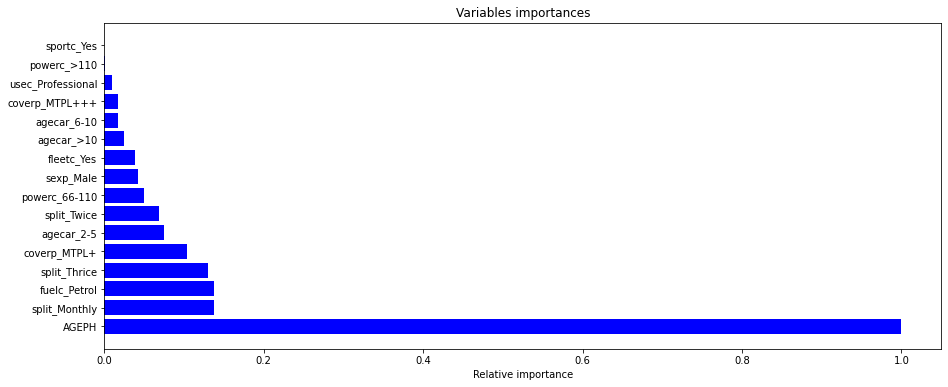

In [ ]:
# Features' names
features = list(X_train_2)

# Importance measures
importances = reg_rf.feature_importances_

# We sort the features by highest importance
indices = np.flip(np.argsort(importances))


#Plot
plt.title('Variables importances')
plt.barh(range(len(indices)), importances[indices] / importances[indices[0]], color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.show()

The age of the policyholder is the most important feature. 

***Partial Dependence Plot (PDP)***

A PDP shows the marginal effect one or two features have on the predicted outcome of a machine learning model. A PDP can show whether the relationship between the target and a feature is linear, monotonic or more complex.

A flat PDP indicates that the feature is not important.

We will show a PDP for the most important feature, the age of the policyholder.

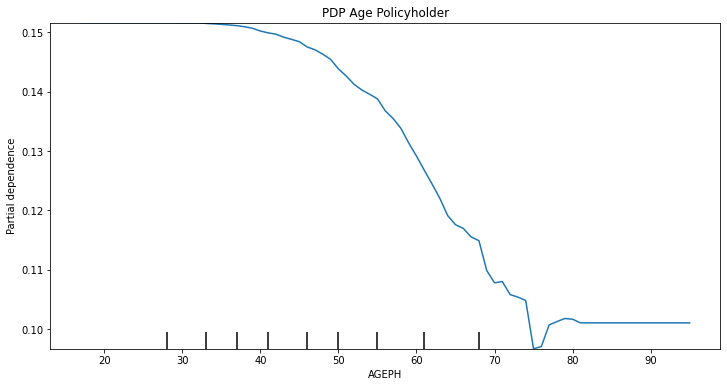

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

#labels=np.flip(features)
labels=['AGEPH']

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDP Age Policyholder")
PartialDependenceDisplay.from_estimator(reg_rf, X = X_train_2, features = labels, ax=ax);

The PDP clearly shows a very high claim frequency for young drivers. The claim frequency decreases until the age of 75 years and slowly increases again for 75+.

#### Method 2 : GBM

In this second section, we will do an Xgboost to compare our frequency model results from the first section.  We will use deviance to compare our models and use a PDP to better understand what the model is giving us in results

##### ***A first GBM***

Below we will launch a first model of Xgboost without hyper parameter tuning in order to have a first view on the Xgboost model

In [ ]:
# import relevant libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
y_mtpl_freq = np.array(y_train_2)
w_mtpl_freq = np.array(my_data_X_train['duree'])

In [ ]:
xgb_frequency = xgb.XGBRegressor(n_estimators = 500,
                                 objective='count:poisson',
                                 max_depth = 3,
                                 learning_rate = 0.01,
                                 base_score = np.sum(y_mtpl_freq * w_mtpl_freq)/np.sum(w_mtpl_freq))

xgb_frequency.fit(X_train_2, y_train_2, sample_weight=w_mtpl_freq)

XGBRegressor(base_score=0.13938126247193397, learning_rate=0.01,
             n_estimators=500, objective='count:poisson')

In [ ]:
y_pred_train_xgb_1 = xgb_frequency.predict(X_train_2)
y_pred_test_xgb_1 = xgb_frequency.predict(X_test_2)

print("Poisson Deviance on training set:", DeviancePoisson_scikit(np.array(y_pred_train_xgb_1),np.array(y_train),np.array(my_data_X_train['duree'])))
print("Poisson Deviance on testing set:", DeviancePoisson_scikit(np.array(y_pred_test_xgb_1),np.array(y_test),np.array(my_data_X_test['duree'])))



Poisson Deviance on training set: 0.30174253790430217
Poisson Deviance on testing set: 0.30297377836764544


Now that we have our 'first view', we will run a random search with CV for hyper parameter tuning in the section below.

##### ***Hyper parameter Tuning***

###### Random search

In [ ]:
# define dictionary for gridsearch
search_dict = {'max_depth':[1,2,3,5,7],
               'learning_rate':[0.0001,0.001,0.01,0.025 ,0.05,0.1,0.5,1],
               'n_estimator': np.append([1],np.arange(start = 50, stop = 501, step = 100)) }

# Initialize an XGBRegressor
xgb_grid = xgb.XGBRegressor(objective='count:poisson',
                            
                            booster='gbtree')


In [ ]:
# execute cross_validation
xgb_randomsearch = RandomizedSearchCV(estimator=xgb_grid,
                                      param_distributions=search_dict,
                                      n_iter=50,
                                      scoring='neg_mean_poisson_deviance',
                                      return_train_score=False,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
xgb_randomsearch.fit(X_train_2, y_train_2, sample_weight=w_mtpl_freq)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=XGBRegressor(objective='count:poisson'),
                   n_iter=50,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.025, 0.05, 0.1, 0.5,
                                                          1],
                                        'max_depth': [1, 2, 3, 5, 7],
                                        'n_estimator': array([  1,  50, 150, 250, 350, 450])},
                   random_state=54321, scoring='neg_mean_poisson_deviance',
                   verbose=1)

In [ ]:
xgb_randomsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimator': 250}

We will perform a grid search around the best parameters found during the random search.

###### Grid Search

In [ ]:
param_grid_xgb = {
                'max_depth':[2,3],
               'learning_rate':[0.08,0.09,0.10,0.11,0.12],
               'n_estimator': np.arange(start = 100, stop = 350, step = 50)
}
param_grid_xgb

{'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
 'max_depth': [2, 3],
 'n_estimator': array([100, 150, 200, 250, 300])}

In [ ]:
# execute cross_validation
xgb_gridsearch = GridSearchCV(estimator=xgb_grid,
                              param_grid=param_grid_xgb,
                              scoring='neg_mean_poisson_deviance',
                              return_train_score=False,
                              verbose=1,
                              cv=5)

xgb_gridsearch.fit(X_train_2, y_train_2, sample_weight=w_mtpl_freq)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=XGBRegressor(objective='count:poisson'),
             param_grid={'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
                         'max_depth': [2, 3],
                         'n_estimator': array([100, 150, 200, 250, 300])},
             scoring='neg_mean_poisson_deviance', verbose=1)

In [ ]:
xgb_gridsearch.best_params_

{'learning_rate': 0.09, 'max_depth': 3, 'n_estimator': 100}

##### ***A XGboost model with tuned hyper parameters***

Our best model has a learning rate of 0.09, a depth of 3 and a number of estimators of 100

###### The model

In [ ]:

xgb_frequency_opti = xgb.XGBRegressor(n_estimators = xgb_gridsearch.best_params_['n_estimator'],
                                 objective='count:poisson',
                                 max_depth = xgb_gridsearch.best_params_['max_depth'],
                                 learning_rate = xgb_gridsearch.best_params_['learning_rate'],
                                 base_score = np.sum(y_mtpl_freq * w_mtpl_freq)/np.sum(w_mtpl_freq))

xgb_frequency_opti.fit(X_train_2, y_train_2, sample_weight=w_mtpl_freq)


XGBRegressor(base_score=0.13938126247193397, learning_rate=0.09,
             objective='count:poisson')

In [ ]:
# Prediction
y_pred_train_xgb = xgb_frequency_opti.predict(X_train_2)
y_pred_test_xgb = xgb_frequency_opti.predict(X_test_2)

print("Poisson Deviance on training set:", DeviancePoisson_scikit(np.array(y_pred_train_xgb),np.array(y_train),np.array(my_data_X_train['duree'])))
print("Poisson Deviance on testing set:", DeviancePoisson_scikit(np.array(y_pred_test_xgb),np.array(y_test),np.array(my_data_X_test['duree'])))

Poisson Deviance on training set: 0.3012231665147244
Poisson Deviance on testing set: 0.3028855076423962


###### Interpretation of the model

Below the relative feature importance. As for the RF, the age of the policyholder is the most important feature.

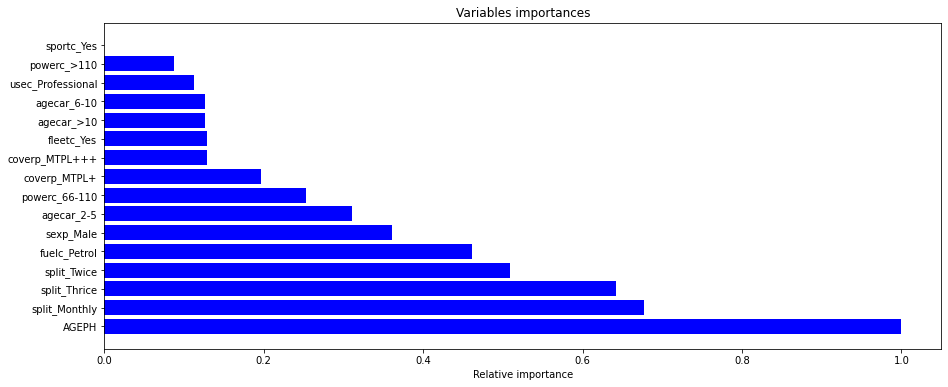

In [ ]:

# Features' names
features_xgb = list(X_train_2)

# Importance measures
importances_xgb = xgb_frequency_opti.feature_importances_

# We sort the features by highest importance
indices = np.flip(np.argsort(importances_xgb))


#Plot
plt.title('Variables importances')
plt.barh(range(len(indices)), importances_xgb[indices] / importances_xgb[indices[0]], color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features_xgb[i] for i in indices])
plt.xlabel('Relative importance')
plt.show()

In [ ]:
from sklearn.utils import validation

validation.check_is_fitted(estimator=xgb_frequency_opti)

NotFittedError: ignored

small trick to get the PDP from Xgboost:

In [ ]:
xgb_frequency_opti.dummy_ = "dummy"
validation.check_is_fitted(estimator=xgb_frequency_opti)

As the policyholder age is the most important feature as in the random forest, we decided to plot the pdp of this variable. We notice that for both methods, the frequency for young people is higher and then tend to decrease until a certain age. In the random forest, the range of the graph is lower between 0.15 and 0.1 while here in the xgboost the range goes from about 0.15 to 0.3. The loss frequency of the PDP of the xgboost is higher for young people  and then decreases and goes up for older people more or less from the age of 75.


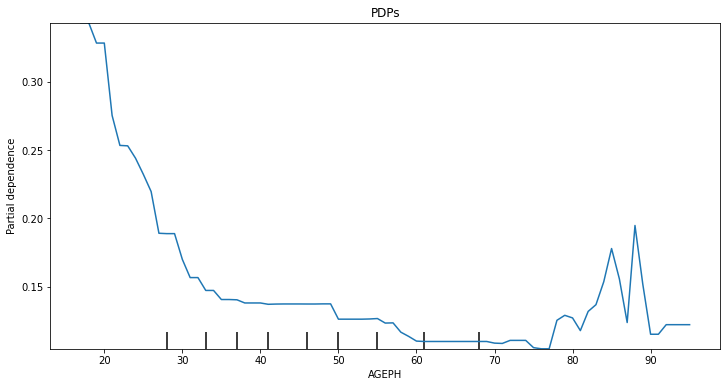

In [ ]:
# PDPs for XGBoost model
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDPs")
PartialDependenceDisplay.from_estimator(xgb_frequency_opti, X=X_train_2,features = ['AGEPH'], ax=ax);

#### Comparison and conclusion

The poisson deviance from the Random Forest model in the training and test set is around 0.305. The Xgboost gave us better poisson deviance (0.301 and 0.302). The deviance improvement seems very small, but as we have seen in the theoretical sessions: a small deviance improvement can in reality be significant.

In conclusion, the Xgboost gave better results in terms of deviance in the training and test set for the claim frequency. In both methods the most important feature was the age and the global trend of the PDP was similar for this feature. 